In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
all_data = pd.read_csv('all_data.csv')

In [3]:
all_data['Bundesland'] = all_data.districtId // 1000

In [4]:
def plot_district(districtId):
    district_data = all_data[all_data.districtId == districtId].copy()
    district_name = district_data.district_name.iat[0]
    x= district_data.week_no
    y1 = district_data.AnzahlFall_cumul
    y2 = district_data.target
    y3 = district_data.target_predicted

    fig, ax1 = plt.subplots()

    color1 = 'gray'
    ax1.set_xlabel('week')
    ax1.set_ylabel('Cumulated Cases', color = color1)
    ax1.plot(x,y1, color = color1,marker='o')
    ax1.tick_params(axis='y', color=color1)
    ax1.set_xlim(x.min(),x.max())
    ax1.set_title(district_name + '\nDashed line - prediction; solid line - observed')

    ax2 = ax1.twinx()
    color2 = 'k'
    ax2.set_ylabel('Weekly Log-R0', color = color2)
    ax2.plot(x, y2, color = color2)
    ax2.plot(x, y3, color = color2, linestyle='--')
    ax2.fill_between(x, y2, y3, where=y3 >= y2,alpha=.6, facecolor='green', interpolate=True)
    ax2.fill_between(x, y2, y3, where=y3 <= y2,alpha=.6, facecolor='red', interpolate=True)
    ax2.tick_params(axis='y', labelcolor = color2)
    ax2.grid(None)

    fig.tight_layout()
        
    plt.show()

In [5]:
ferien_dict = {8:31,
               9:31,
               11:27,
               12:27,
               4:25,
               2:27,
               6:28,
               13:26,
               3:30,
               5:27,
               7:28,
               10:28,
               14:30,
               15:30,
               1:27,
               16:30}

summer_vac_df = pd.DataFrame()

for bl,start in ferien_dict.items():
    ferien = [start+x for x in range(0,7)]
    #six weeks of vacation plus one extra for all travel returnees to get tested
    bl_data = all_data.loc[all_data.Bundesland==bl,['districtId','week_no']].copy()
    bl_data['summer_vac'] = bl_data.week_no.isin(ferien)
    summer_vac_df = summer_vac_df.append(bl_data)
    
all_data = pd.merge(all_data, summer_vac_df, how='outer')
    


In [6]:
def deviance_sum_interval(first_week, last_week):
    cut_data = all_data[all_data.week_no.between(first_week,last_week, inclusive=True)].copy()
    deviance_sums = cut_data.groupby('districtId')['deviance'].mean().reset_index()
    return deviance_sums

In [7]:
lockdown = deviance_sum_interval(12,21)
summer = all_data[all_data.summer_vac].groupby('districtId')['deviance'].mean().reset_index()
deviance_merge = pd.merge(lockdown, summer,
                      on='districtId',how='outer',
                      suffixes=('_lockdown','_summer'))

In [8]:
structural = all_data[['districtId','district_name','rur_z','ses_z']].drop_duplicates()
deviance_df = deviance_merge.merge(structural).set_index('districtId')

In [9]:
deviance_df.head()

,deviance_lockdown,deviance_summer,district_name,rur_z,ses_z
districtId,,,,,
1001,-0.065371,-0.201249,"Flensburg, Stadt",-1.294640,-0.754626
1002,0.165574,-0.247563,KS Kiel,-1.693752,-0.083339
1003,0.133015,-0.101876,KS Lübeck,-1.072525,-0.424751
1004,0.044497,-0.274591,"Neumünster, Stadt",-0.758816,-0.735324
1051,0.063276,-0.032591,Dithmarschen,1.243732,-0.703769


In [10]:
deviance_z_df = pd.DataFrame()
scaler = StandardScaler()

for i in deviance_df.index:
    center_rur = deviance_df.rur_z.at[i]
    center_ses = deviance_df.ses_z.at[i]
    distances = np.sqrt((deviance_df.rur_z - center_rur)**2 + (deviance_df.ses_z - center_ses)**2)
    peers_df = deviance_df[distances <= 1].copy()
    n_peer_kernel = peers_df.shape[0]
    output_dict = {'districtId':i,
                  'n_peer_kernel':n_peer_kernel}
    for t in ['lockdown','summer']:
        var_name = t + '_z'
        peers_df[var_name] = scaler.fit_transform(peers_df['deviance_' + t].values.reshape(-1,1))
        output_dict[var_name] = peers_df[var_name].at[i]
        
        
    deviance_z_df = deviance_z_df.append(output_dict, ignore_index=True)
       

In [11]:
deviance_df = pd.merge(deviance_df.reset_index(),deviance_z_df)

In [12]:
for c in ['lockdown_z','summer_z']:
    print(c)
    for cut_off in [1.96, 2.33, 2.58]:
        above_df = deviance_df[deviance_df[c] >= cut_off]
        print('Above',cut_off,'cut-off:',above_df.shape[0],'\nincluding',
             sum(above_df.n_peer_kernel < 31),'with fewer than 30 peers and',
             sum(above_df.n_peer_kernel < 21),'with fewer than 20 peers.')

lockdown_z
Above 1.96 cut-off: 5 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.33 cut-off: 1 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.58 cut-off: 0 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
summer_z
Above 1.96 cut-off: 14 
including 2 with fewer than 30 peers and 2 with fewer than 20 peers.
Above 2.33 cut-off: 6 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.
Above 2.58 cut-off: 4 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.


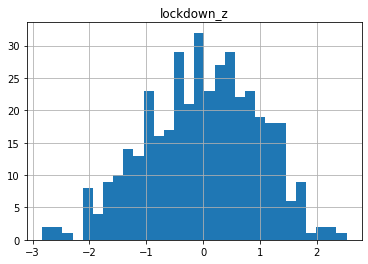

     districtId  deviance_lockdown  deviance_summer   district_name     rur_z  \
142        7111           0.393950         0.007819      KS Koblenz -1.159922   
211        8336           0.355834        -0.180121         Lörrach -0.025397   
294        9663           0.326337        -0.408187     KS Würzburg -1.289142   
169        7332           0.326071        -0.207335    Bad Dürkheim  0.301302   
99         5758           0.320184        -0.036144         Herford -0.082882   
380       16053           0.299357        -0.291328         KS Jena -1.161131   
220        8436           0.302855         0.039902      Ravensburg  0.366471   
254        9277           0.280861        -0.456190      Rottal-Inn  1.098552   
186        8126           0.292661        -0.045482  Hohenlohekreis  0.765012   
148        7137           0.284614        -0.253372   Mayen-Koblenz  0.249259   

        ses_z  lockdown_z  n_peer_kernel  summer_z  
142  0.693709    2.524453           61.0  0.974924  
21

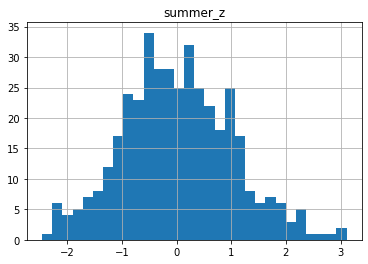

     districtId  deviance_lockdown  deviance_summer      district_name  \
62         4012          -0.300531         0.367205     KS Bremerhaven   
98         5754          -0.043951         0.323569          Gütersloh   
256        9279           0.018599         0.466505  Dingolfing-Landau   
27         3251          -0.004168         0.332407           Diepholz   
369       15083           0.145502         0.344395              Börde   
31         3256           0.006336         0.269696   Nienburg (Weser)   
61         4011          -0.214596         0.212505          KS Bremen   
372       15086          -0.075183         0.382931    Jerichower Land   
42         3360           0.068837         0.251799             Uelzen   
222        9161          -0.232166         0.098647      KS Ingolstadt   

        rur_z     ses_z  lockdown_z  n_peer_kernel  summer_z  
62  -1.314766 -0.911372   -1.968546           31.0  3.110182  
98   0.033483  0.841294   -0.859171          142.0  2.94670

In [13]:
for c in ['lockdown_z','summer_z']:
    deviance_df[c].hist(bins=30)
    plt.title(c)
    plt.show()
    print(deviance_df.sort_values(c,ascending=False).head(10))

Best during lockdown


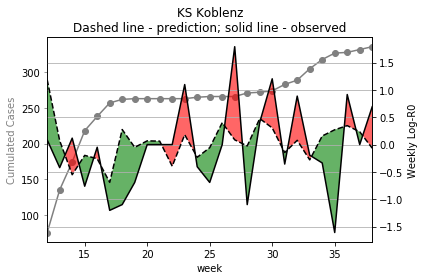

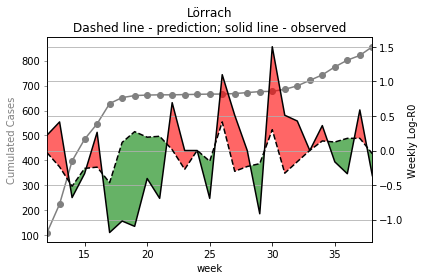

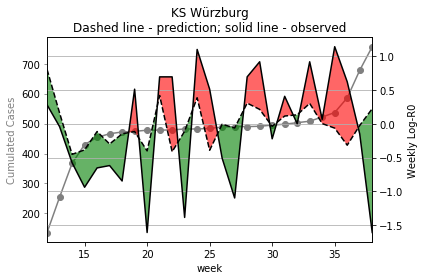

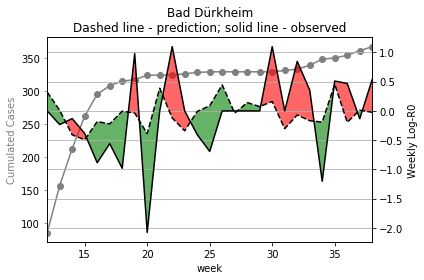

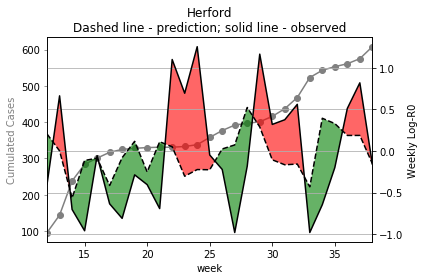

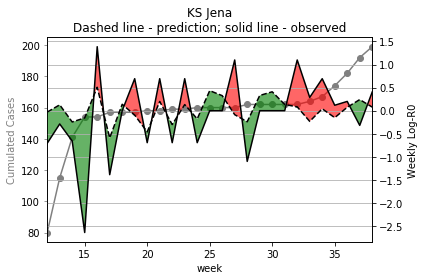

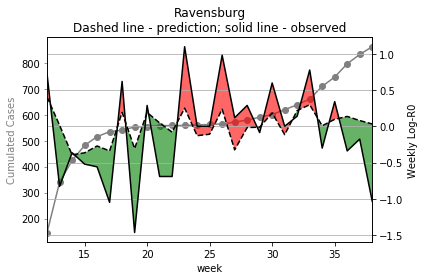

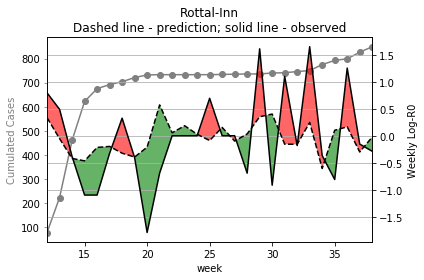

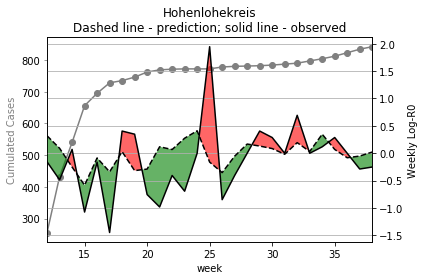

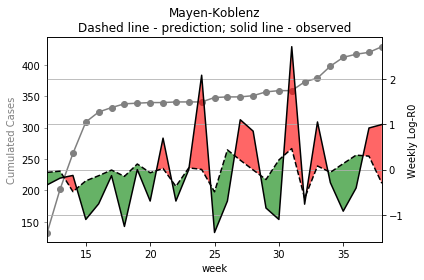

Worst during lockdown


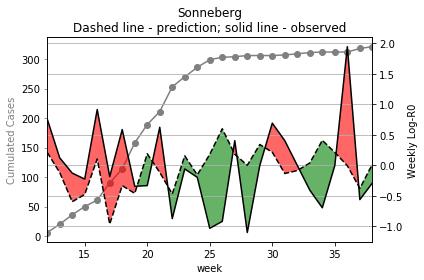

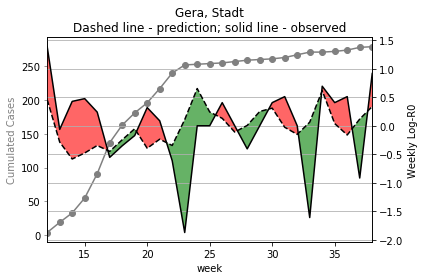

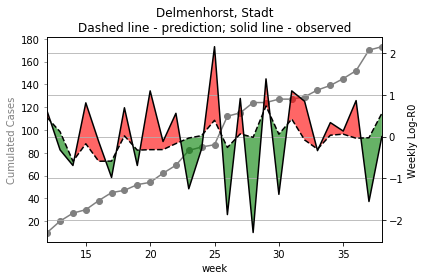

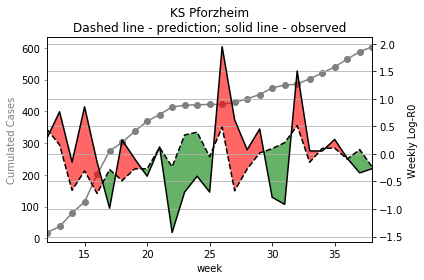

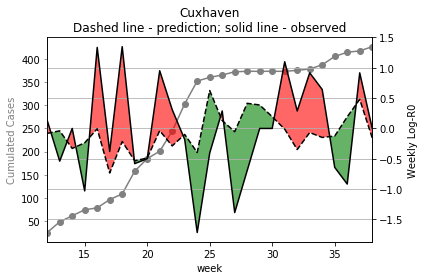

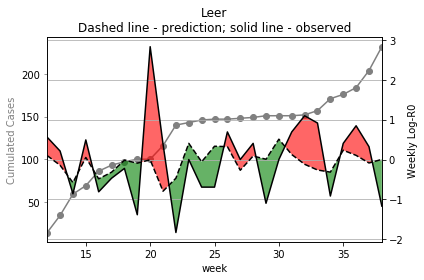

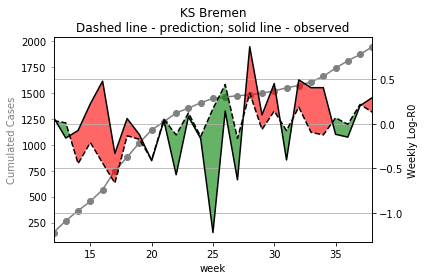

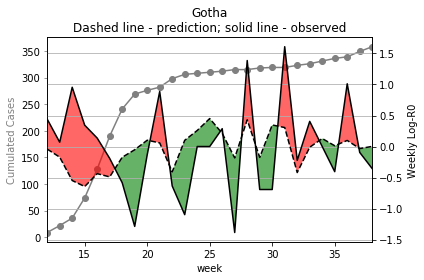

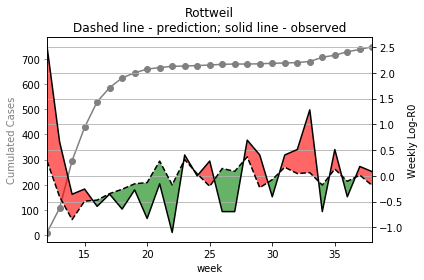

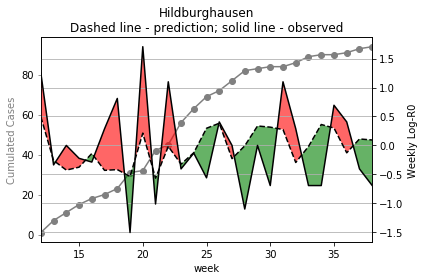

Best during summer


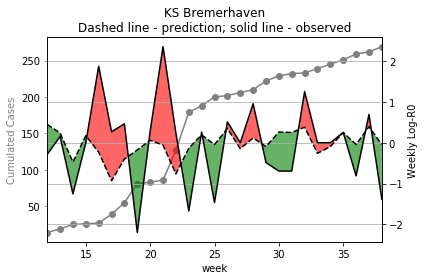

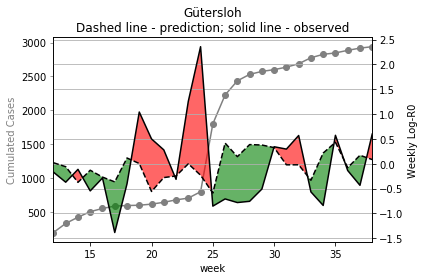

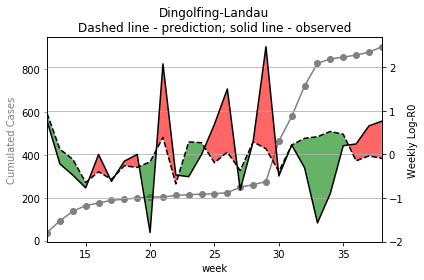

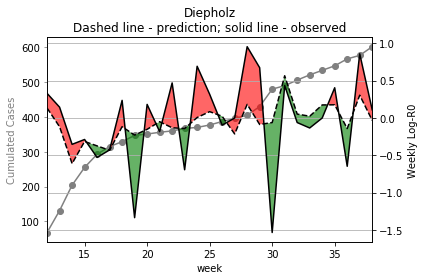

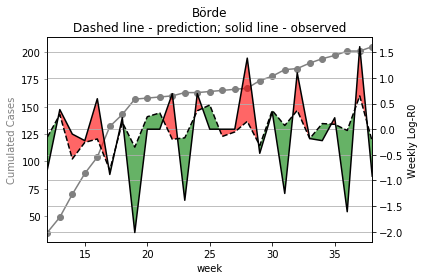

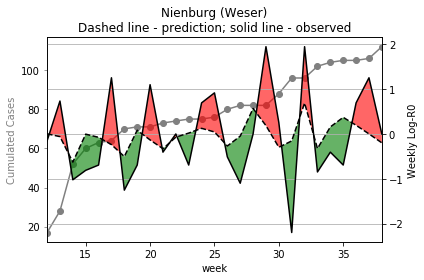

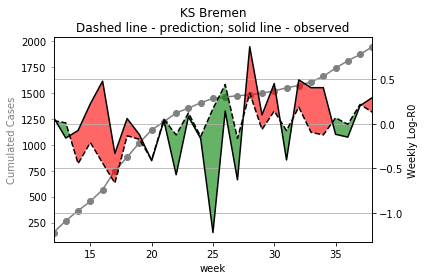

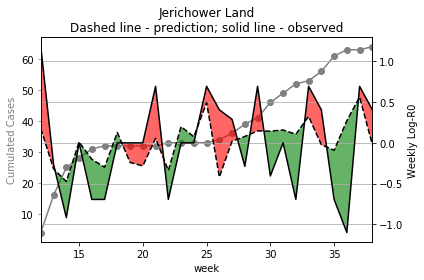

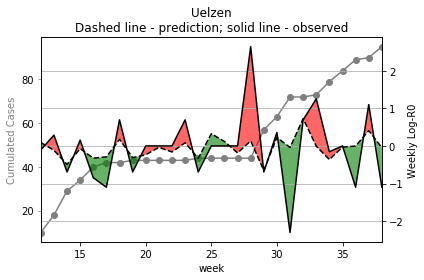

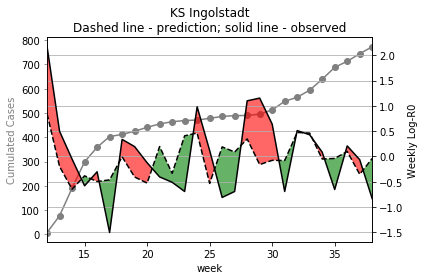

Worst during summer


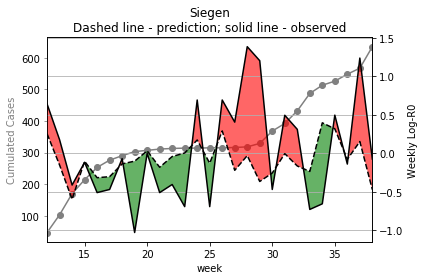

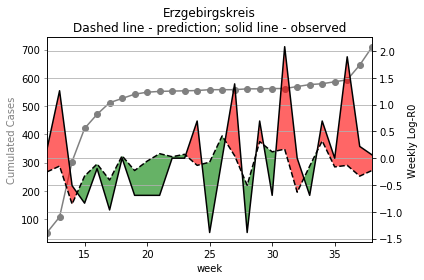

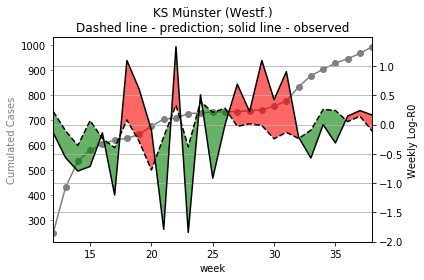

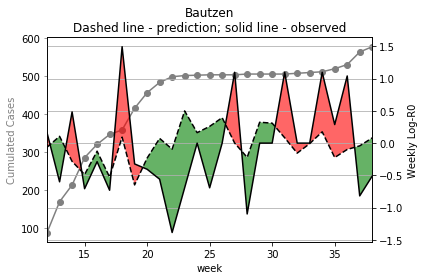

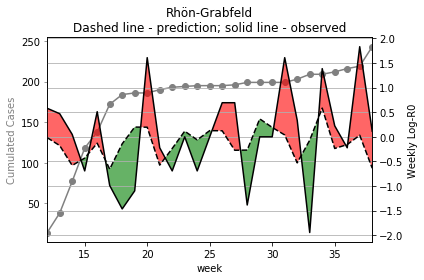

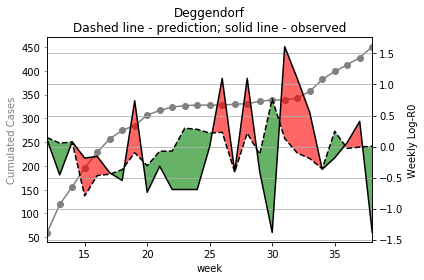

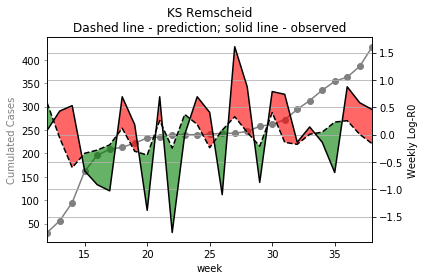

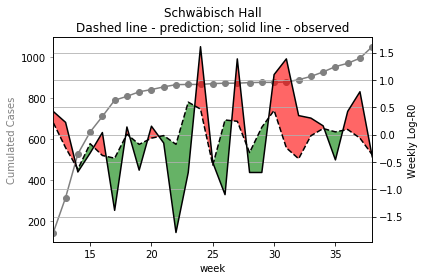

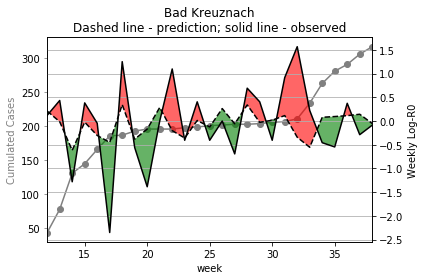

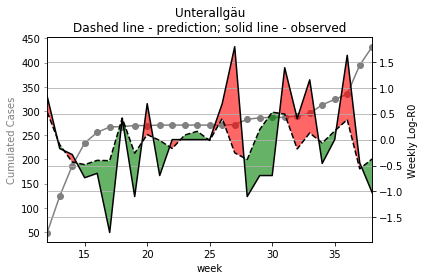

In [14]:
def top_flop_n(n, var, flop=False):
    sorted_df = deviance_df.sort_values(var,ascending=flop)
    for i in range(n):
        plot_district(sorted_df.districtId.iat[i])

N=10 

for var in ['lockdown_z','summer_z']:
    
    print('Best during',var[:-2])
    top_flop_n(N,var,flop=False)
    
    print('Worst during',var[:-2])
    top_flop_n(N,var,flop=True)

Text(0.5, 1.0, 'Summer: final PD score (x) vs raw aggregated deviance (y)')

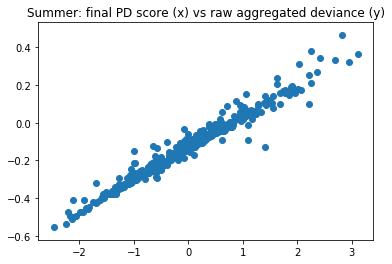

In [15]:
plt.scatter(deviance_df.summer_z,deviance_df.deviance_summer)
plt.title('Summer: final PD score (x) vs raw aggregated deviance (y)')

Text(0.5, 1.0, 'Lockdown: final PD score (x) vs raw aggregated deviance (y)')

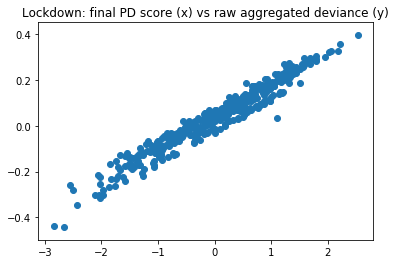

In [16]:
plt.scatter(deviance_df.lockdown_z,deviance_df.deviance_lockdown)
plt.title('Lockdown: final PD score (x) vs raw aggregated deviance (y)')